In [1]:
## 라이브러리를 설치해줍니다.
!pip install segmentation_models_pytorch
!pip install torch_optimizer 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=aec7e8fa833e6b99fb81830cc4e74625c16cf9e08aa9a79522baf9feca5a0e6d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=5d8470951c1e41b51b0df27276e1437c77c14e81094c6959d62258fc4ee3654f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.7 MB/s eta 0:00:00


# Library

In [2]:
## 라이브러리를 불러옵니다.
import random
import numpy as np
import pydicom
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import os
from PIL import Image
import segmentation_models_pytorch as smp
import wandb
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split
import albumentations as A
import cv2
import torch_optimizer as optim


# Model

In [3]:
# Pretrained SegFormer Model Import를 위한 라이브러리를 불러옵니다.
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# label을 설정합니다. label의 이름까지 달아주지는 않고, 그냥 숫자 (0-12)로만 처리합니다.
id2label = {i : i for i in range(13)}
label2id = id2label

# model loading
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512", 
                                                         id2label=id2label, label2id=label2id,
                                                        ignore_mismatched_sizes=True).to("cuda")


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([13, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## CoordConv layer를 새로 정의해줍니다.
## https://github.com/walsvid/CoordConv/blob/master/coordconv.py 참조.

class AddCoords(nn.Module):
    def __init__(self, rank, with_r=False, use_cuda=True):
        super(AddCoords, self).__init__()
        self.rank = rank
        self.with_r = with_r
        self.use_cuda = use_cuda

    def forward(self, input_tensor):
        """
        :param input_tensor: shape (N, C_in, H, W)
        :return:
        """
        if self.rank == 1:
            batch_size_shape, channel_in_shape, dim_x = input_tensor.shape
            xx_range = torch.arange(dim_x, dtype=torch.int32)
            xx_channel = xx_range[None, None, :]

            xx_channel = xx_channel.float() / (dim_x - 1)
            xx_channel = xx_channel * 2 - 1
            xx_channel = xx_channel.repeat(batch_size_shape, 1, 1)

            if torch.cuda.is_available and self.use_cuda:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
            out = torch.cat([input_tensor, xx_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)

        elif self.rank == 2:
            batch_size_shape, channel_in_shape, dim_y, dim_x = input_tensor.shape
            xx_ones = torch.ones([1, 1, 1, dim_x], dtype=torch.int32)
            yy_ones = torch.ones([1, 1, 1, dim_y], dtype=torch.int32)

            xx_range = torch.arange(dim_y, dtype=torch.int32)
            yy_range = torch.arange(dim_x, dtype=torch.int32)
            xx_range = xx_range[None, None, :, None]
            yy_range = yy_range[None, None, :, None]

            xx_channel = torch.matmul(xx_range, xx_ones)
            yy_channel = torch.matmul(yy_range, yy_ones)

            # transpose y
            yy_channel = yy_channel.permute(0, 1, 3, 2)

            xx_channel = xx_channel.float() / (dim_y - 1)
            yy_channel = yy_channel.float() / (dim_x - 1)

            xx_channel = xx_channel * 2 - 1
            yy_channel = yy_channel * 2 - 1

            xx_channel = xx_channel.repeat(batch_size_shape, 1, 1, 1)
            yy_channel = yy_channel.repeat(batch_size_shape, 1, 1, 1)

            if torch.cuda.is_available and self.use_cuda:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
                yy_channel = yy_channel.cuda()
            out = torch.cat([input_tensor, xx_channel, yy_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) + torch.pow(yy_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)

        elif self.rank == 3:
            batch_size_shape, channel_in_shape, dim_z, dim_y, dim_x = input_tensor.shape
            xx_ones = torch.ones([1, 1, 1, 1, dim_x], dtype=torch.int32)
            yy_ones = torch.ones([1, 1, 1, 1, dim_y], dtype=torch.int32)
            zz_ones = torch.ones([1, 1, 1, 1, dim_z], dtype=torch.int32)

            xy_range = torch.arange(dim_y, dtype=torch.int32)
            xy_range = xy_range[None, None, None, :, None]

            yz_range = torch.arange(dim_z, dtype=torch.int32)
            yz_range = yz_range[None, None, None, :, None]

            zx_range = torch.arange(dim_x, dtype=torch.int32)
            zx_range = zx_range[None, None, None, :, None]

            xy_channel = torch.matmul(xy_range, xx_ones)
            xx_channel = torch.cat([xy_channel + i for i in range(dim_z)], dim=2)
            xx_channel = xx_channel.repeat(batch_size_shape, 1, 1, 1, 1)

            yz_channel = torch.matmul(yz_range, yy_ones)
            yz_channel = yz_channel.permute(0, 1, 3, 4, 2)
            yy_channel = torch.cat([yz_channel + i for i in range(dim_x)], dim=4)
            yy_channel = yy_channel.repeat(batch_size_shape, 1, 1, 1, 1)

            zx_channel = torch.matmul(zx_range, zz_ones)
            zx_channel = zx_channel.permute(0, 1, 4, 2, 3)
            zz_channel = torch.cat([zx_channel + i for i in range(dim_y)], dim=3)
            zz_channel = zz_channel.repeat(batch_size_shape, 1, 1, 1, 1)

            if torch.cuda.is_available and self.use_cuda:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
                yy_channel = yy_channel.cuda()
                zz_channel = zz_channel.cuda()
            out = torch.cat([input_tensor, xx_channel, yy_channel, zz_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) +
                                torch.pow(yy_channel - 0.5, 2) +
                                torch.pow(zz_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)
        else:
            raise NotImplementedError

        return out

class CoordConv2d(conv.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, with_r=False, use_cuda=True):
        super(CoordConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                          stride, padding, dilation, groups, bias)
        self.rank = 2
        self.addcoords = AddCoords(self.rank, with_r, use_cuda=use_cuda)
        self.conv = nn.Conv2d(in_channels + self.rank + int(with_r), out_channels,
                              kernel_size, stride, padding, dilation, groups, bias)

    def forward(self, input_tensor):
        """
        input_tensor_shape: (N, C_in,H,W)
        output_tensor_shape: N,C_out,H_out,W_out）
        :return: CoordConv2d Result
        """
        out = self.addcoords(input_tensor)
        out = self.conv(out)

        return out

In [5]:
## SegFormer 내의 모든 conv2d 모듈을 Coordconv2d 모듈로 변경해줍니다.

modules_to_replace = []

def replace_conv2d_with_coordconv(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            modules_to_replace.append((name, child))
            print(f"{name}: {child}")
        else:
            # Recursively call replace_conv2d_with_coordconv for child modules
            replace_conv2d_with_coordconv(child)
            
replace_conv2d_with_coordconv(model)
 
for name, module in modules_to_replace:
    in_channels = module.in_channels
    out_channels = module.out_channels
    kernel_size = module.kernel_size
    stride = module.stride
    padding = module.padding
    dilation = module.dilation
    groups = 1
    bias = module.bias is not None

    coord_conv2d = CoordConv2d(in_channels, out_channels, kernel_size, stride,
                               padding, dilation, groups, bias)
    setattr(model, name, coord_conv2d)


proj: Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
proj: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
proj: Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
proj: Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
sr: Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
dwconv: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
sr: Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
dwconv: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
sr: Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
dwconv: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
sr: Conv2d(128, 128, kernel_size=(4, 4), stride=(4, 4))
dwconv: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
sr: Conv2d(128, 128, kernel_size=(4, 4), stride=(4, 4))
dwconv: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups

In [6]:
## 실험 시 모델 인코더 freeze를 위한 부분입니다. 실제 Training 시에는 사용하지 않았습니다.
# for name, params in model.named_parameters():
#     if 'encoder' in name:
#         params.requires_grad = True
#     else: params.requires_grad = False

# Seed & Device

In [7]:
# 시드를 고정해줍니다.
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device를 설정해줍니다.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Dataset & Dataloader

In [8]:
datapath = '/kaggle/input/aikuthon-2023-01/data/data'
train_ims = list(sorted(os.listdir(datapath + '/train/imgs')))
train_msks = list(sorted(os.listdir(datapath + '/train/masks')))
test_ims = list(sorted(os.listdir(datapath + '/test/imgs')))

img_path = '/kaggle/input/aikuthon-2023-01/data/data/train/imgs'
msk_path = '/kaggle/input/aikuthon-2023-01/data/data/train/masks'

In [9]:
class SSDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, msk_dir, image_list, transforms=None):
        self.transforms = transforms
        self.imgs = image_list
        self.img_dir, self.msk_dir = img_dir, msk_dir
        self.labels = list(range(0,13))
    
    def __getitem__(self, idx):
            file_image = f'train_{idx+1:04d}.png'
            mask_image = f'train_{idx+1:04d}.png'
            img_path = os.path.join(self.img_dir, file_image)
            mask_path = os.path.join(self.msk_dir, mask_image)
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("RGB")
            image = np.array(image, dtype=np.float32)
            mask = np.array(mask, dtype=np.float32)[:,:,0]
            image = torch.from_numpy(image)
            image = image.permute(2,0,1)
            mask = np.array([(mask == v) for v in list(self.labels)])
            mask = np.stack(mask, axis=0).astype('float')
            
            mask = torch.from_numpy(mask)

            if self.transforms is not None:
                image = self.transforms(image)
                mask = self.transforms(mask)

            return image, mask

    
    def __len__(self):
        return len(self.imgs)
       
        

In [10]:
class SSDatasetTest(torch.utils.data.Dataset):
    def __init__(self, img_dir, msk_dir, image_list, transforms=None):
        self.transforms = transforms
        self.imgs = image_list
        self.img_dir, self.msk_dir = img_dir, msk_dir
        self.labels = list(range(0,13))
    
    def __getitem__(self, idx):
        file_image = f'test_{idx+1:04d}.png'
        img_path = os.path.join(self.img_dir, file_image)
        image = Image.open(img_path).convert("RGB")
        image = np.array(image, dtype=np.float32)
        image = torch.from_numpy(image)
        image = image.permute(2,0,1)
        if self.transforms is not None:
            image = self.transforms(image)
        return image

    
    def __len__(self):
        return len(self.imgs)
    

In [11]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.__name__ = 'dice_loss'

    def forward(self, pred, target):
        pred = F.interpolate(pred.logits, scale_factor=4, mode='bilinear', align_corners=False)
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(pred * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(pred * pred)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        return 1 - loss
    
    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.__name__ = 'dice_bce_loss'

    def forward(self, pred, targets, smooth=1):
#         print(pred.logits.shape, targets.shape)
        #flatten label and prediction tensors
        inputs = F.sigmoid(pred.logits) 
        inputs = F.interpolate(inputs, scale_factor=4, mode='bilinear', align_corners=False).reshape(-1).float()
        targets = targets.reshape(-1).float()
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = 0.75 * BCE + 0.25*dice_loss
        
        return Dice_BCE


In [12]:
dataset = SSDataset(img_path, msk_path, train_ims)

train_len = int(len(dataset) * 0.7)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = False)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False)

In [13]:
## Data의 input과 output resolution이 맞는 지 확인하기 위한 코드입니다.

for i, data in enumerate(train_dataloader):
    print(model(data[0].to(device)).logits.shape)
    print(data[1].shape)
    if i==2:
        break

torch.Size([4, 13, 150, 200])
torch.Size([4, 13, 600, 800])
torch.Size([4, 13, 150, 200])
torch.Size([4, 13, 600, 800])
torch.Size([4, 13, 150, 200])
torch.Size([4, 13, 600, 800])


In [14]:
## IoU를 구현하기 위한 코드입니다.

def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x

def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union

class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class IoU(Metric):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = F.interpolate(y_pr.logits, scale_factor=4, mode='bilinear', align_corners=False)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [21]:
from segmentation_models_pytorch import utils as U

loss = DiceBCELoss()
metrics = [IoU(threshold=0.5)]
# optimizer = optim.RAdam(
#     model.parameters(),
#     lr= 1e-3,
#     betas=(0.9, 0.999),
#     eps=1e-8,
#     weight_decay=0,
# )

# optimizer = optim.AdaBound(
#     model.parameters(),
#     lr= 1e-3,
#     betas= (0.9, 0.999),
#     final_lr = 0.1,
#     gamma=1e-3,
#     eps= 1e-8,
#     weight_decay=0,
#     amsbound=False,
# )

optimizer = torch.optim.AdamW([dict(params=model.parameters(), lr=0.001)])

num_epochs = 20
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5, eta_min=0.00001, verbose=True)


total_loss = 0

# Train for one epoch
te = smp.utils.train.TrainEpoch(model, loss=loss, optimizer=optimizer, metrics=metrics, device='cuda')

# Validate on the validation set
ve = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device='cuda')

best_loss = 1000

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training
    train_logs = te.run(train_dataloader)
    
    # Validation
    val_logs = ve.run(val_dataloader)
    
    # Update the scheduler
    scheduler.step()
    
    # Print the logsc
    print(f"Train loss: {train_logs['dice_bce_loss']:.4f} | Train IoU: {train_logs['iou_score']:.4f}")
    print(f"Val loss: {val_logs['dice_bce_loss']:.4f} | Val IoU: {val_logs['iou_score']:.4f}")
    print("=" * 30)
    
    if best_loss > val_logs['dice_bce_loss']:
        best_loss = val_logs['dice_bce_loss']
        torch.save(model, './best_model.pth')
            
        torch.save(model.state_dict(), './best_params.pth')
        print('Model saved!')


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/20
valid: 100%|██████████| 289/289 [04:08<00:00,  1.16it/s, dice_bce_loss - 0.02008, iou_score - 0.9435]
Adjusting learning rate of group 0 to 9.0546e-04.
Train loss: 0.0227 | Train IoU: 0.9355
Val loss: 0.0201 | Val IoU: 0.9435
Model saved!
Epoch 2/20
valid: 100%|██████████| 289/289 [04:09<00:00,  1.16it/s, dice_bce_loss - 0.02122, iou_score - 0.9405]
Adjusting learning rate of group 0 to 6.5796e-04.
Train loss: 0.0258 | Train IoU: 0.9271
Val loss: 0.0212 | Val IoU: 0.9405
Epoch 3/20
valid: 100%|██████████| 289/289 [04:08<00:00,  1.16it/s, dice_bce_loss - 0.01956, iou_score - 0.9461]
Adjusting learning rate of group 0 to 3.5204e-04.
Train loss: 0.0203 | Train IoU: 0.9433
Val loss: 0.0196 | Val IoU: 0.9461
Model saved!
Epoch 4/20
valid: 100%|██████████| 289/289 [04:19<00:00,  1.12it/s, dice_bce_loss - 0.01921, iou_score - 0.9473]
Adjusting learning rate of group 0 to 1.0454e-04.
Train loss: 0.0195 | Train IoU: 0.9462
Val loss: 0

KeyboardInterrupt: 

# Inference

In [22]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

test_model=model.to(device)

###batch_size=1, shuffle=False로 해야합니다. 그래야 sample_submission에 나와있는 img_id순서와 동일하게 순서가 일치하게 됩니다.
test_dataset = SSDatasetTest('/kaggle/input/aikuthon-2023-01/data/data/test/imgs', None, test_ims, transforms=None)
testloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)
test_model.eval()


out_dict = []
output = []
inputs = []

for i,image in tqdm(enumerate(testloader)):
    image = image.to(device)
    prediction = test_model(image).logits
    prediction = F.interpolate(prediction, scale_factor=4, mode='bilinear', align_corners=False)
    ### segmentation이기에 가장 확률이 높은 index만을 찾아줍니다.
    prediction = prediction.argmax(dim=1)
    ##prediction shape: [1,600,800]

    mask_labels = []
    image_name = test_ims[i].rsplit('.')[0]
    
    ##제출코드 및 RLE encoding을 해주는 방법입니다.
    for j in range(13):
        mask_label = torch.zeros(prediction.shape)
        mask_label[prediction==j]=1
            
        mask_labels.append(mask_label)
        
    for j in range(0,13):
        mask_label = mask_labels[j].squeeze().numpy()
        encode = rle_encode(mask_label)
        out_dict.append((f'{image_name}_{j}', ' '.join(str(_) for _ in encode)))
    
## csv만드는 코드입니다.
import pandas as pdb

df = pdb.DataFrame(out_dict)
df.columns=['ImageId','EncodedPixels']
df=df.set_index('ImageId')

df.to_csv('/kaggle/working/result.csv')


1150it [03:23,  5.65it/s]


In [23]:
import matplotlib.pyplot as plt
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

0it [00:00, ?it/s]

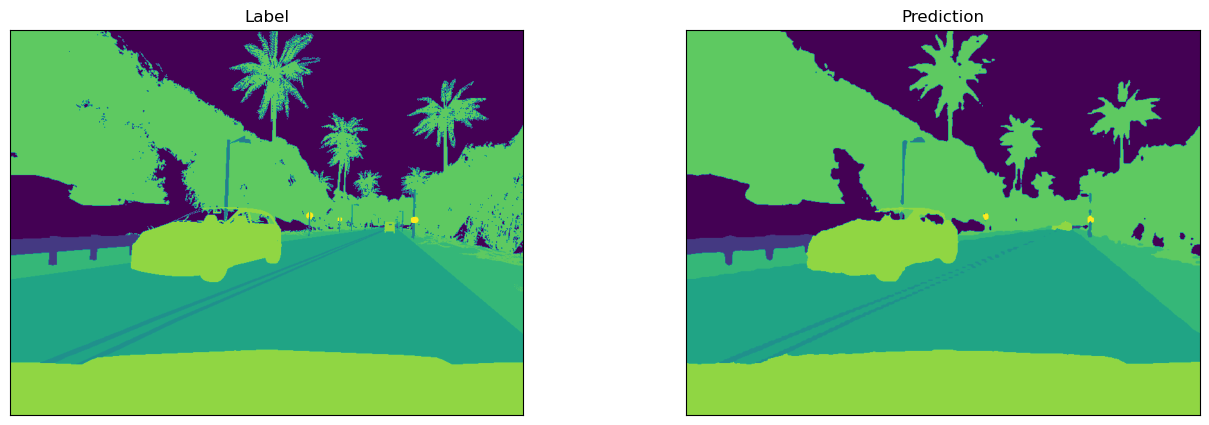

1it [00:01,  1.81s/it]

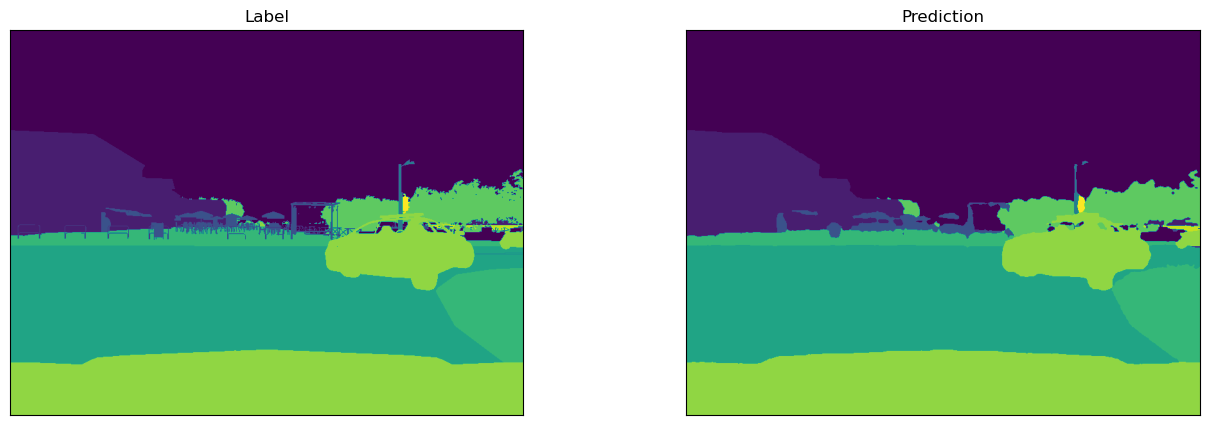

2it [00:03,  1.74s/it]

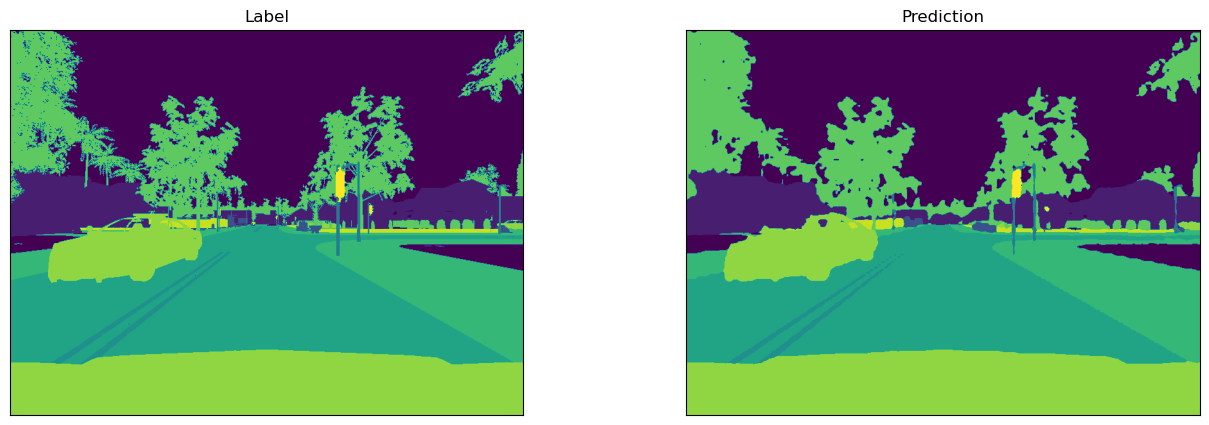

3it [00:05,  1.97s/it]

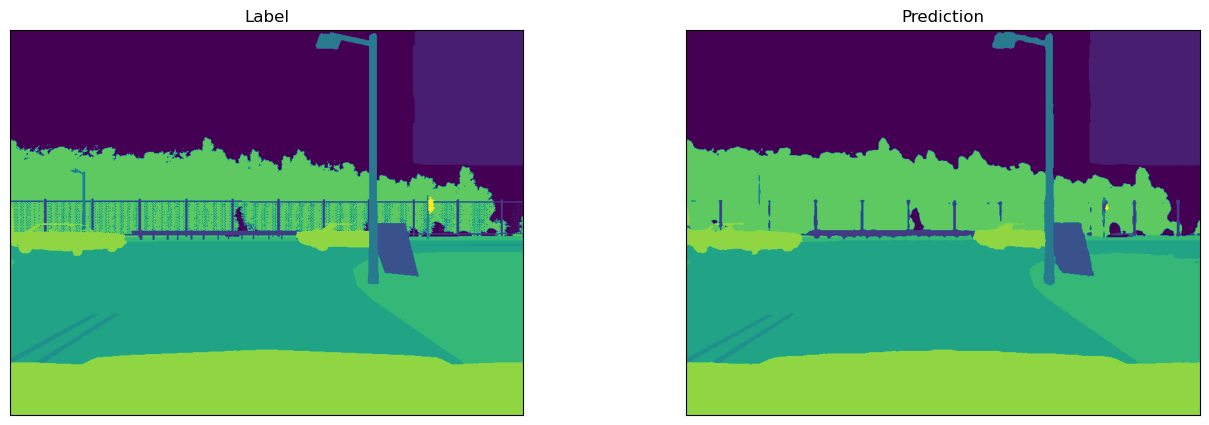

4it [00:07,  1.84s/it]

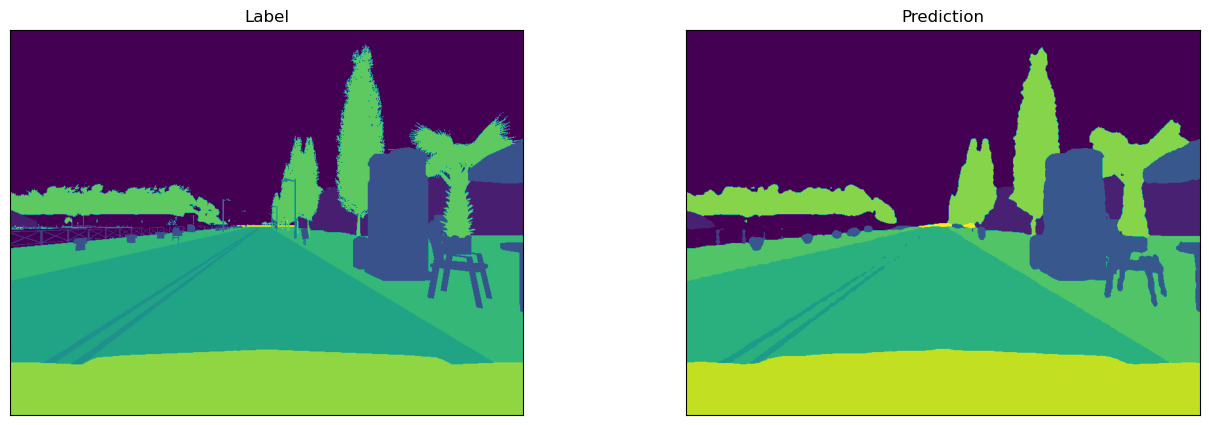

5it [00:09,  1.76s/it]

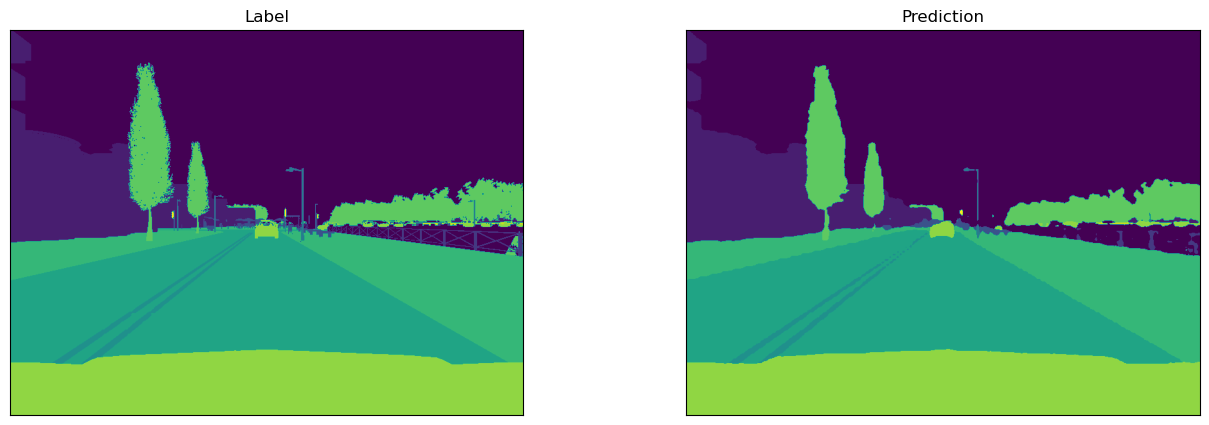

6it [00:10,  1.70s/it]

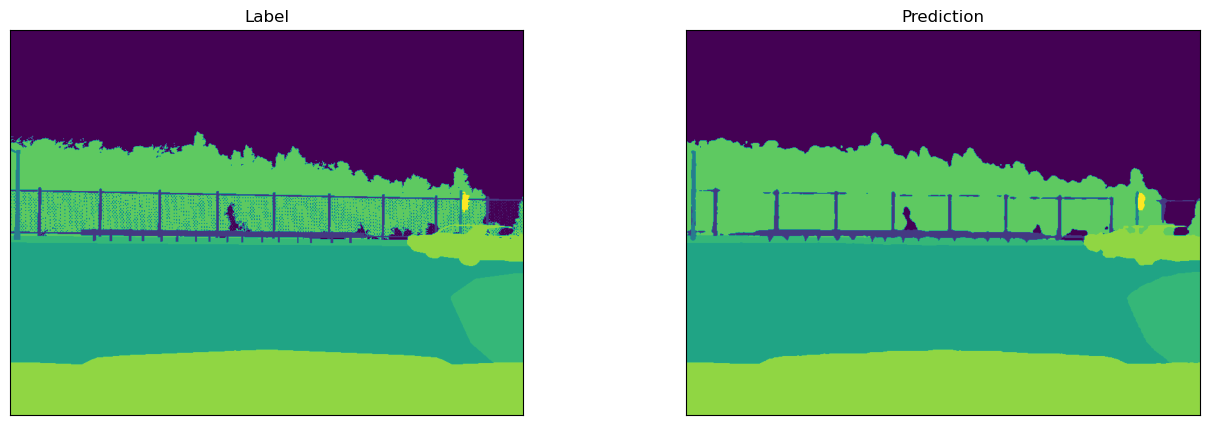

7it [00:12,  1.67s/it]

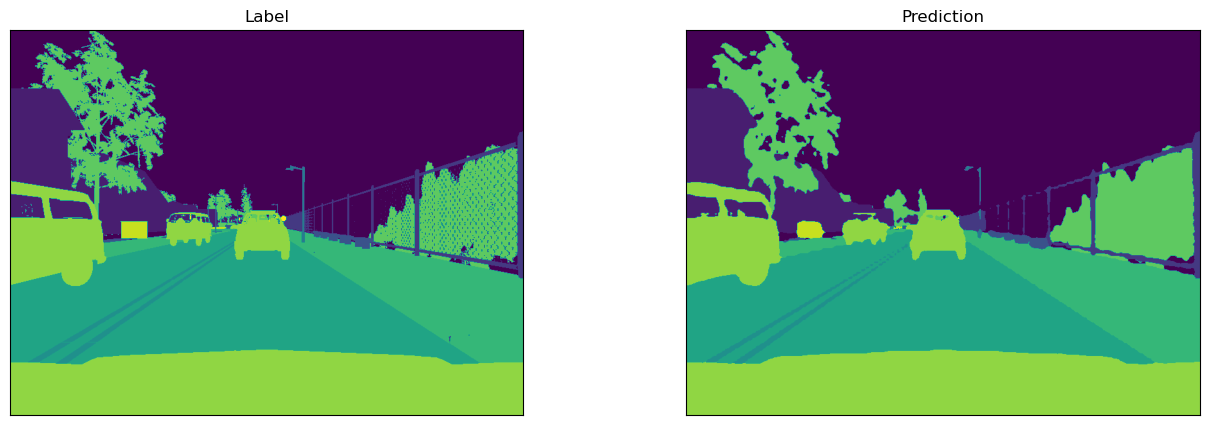

8it [00:13,  1.63s/it]

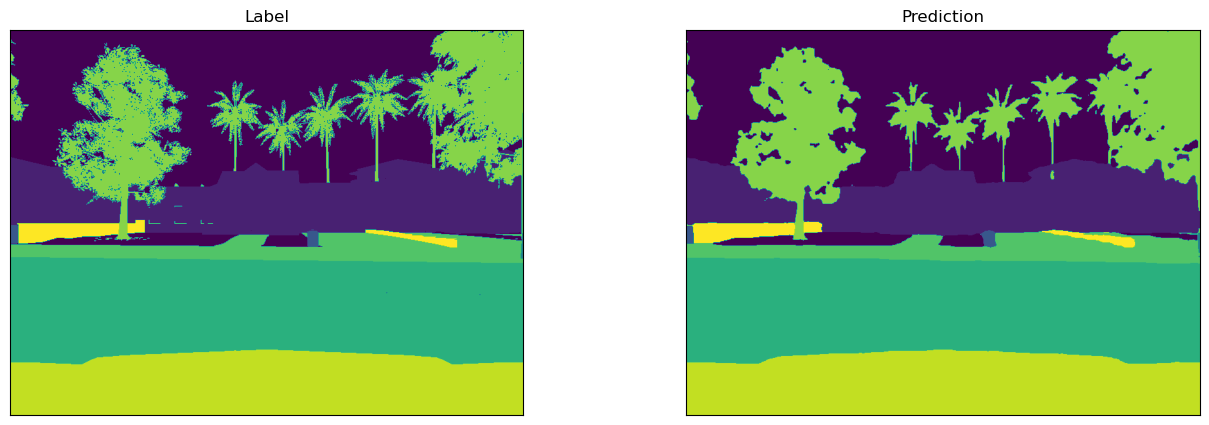

9it [00:15,  1.62s/it]

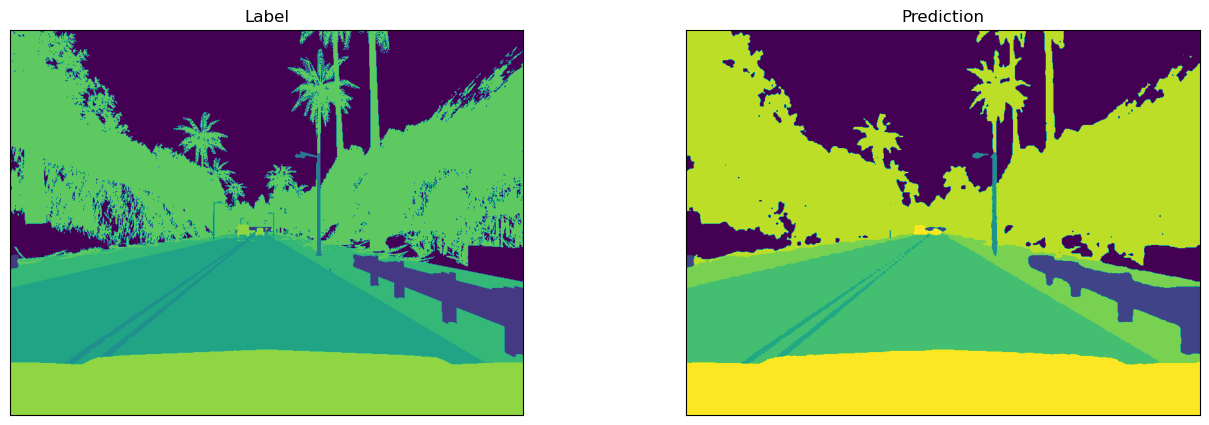

10it [00:16,  1.61s/it]

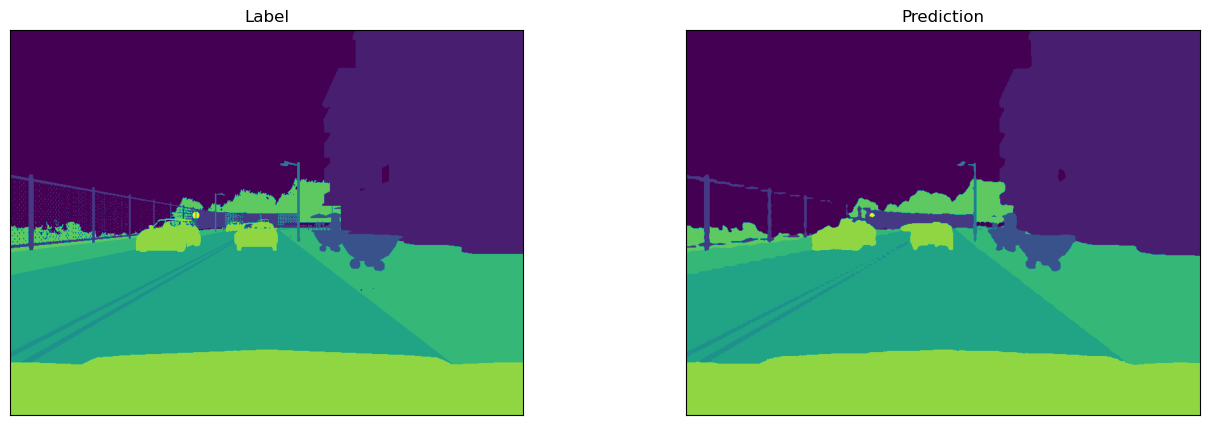

11it [00:18,  1.62s/it]

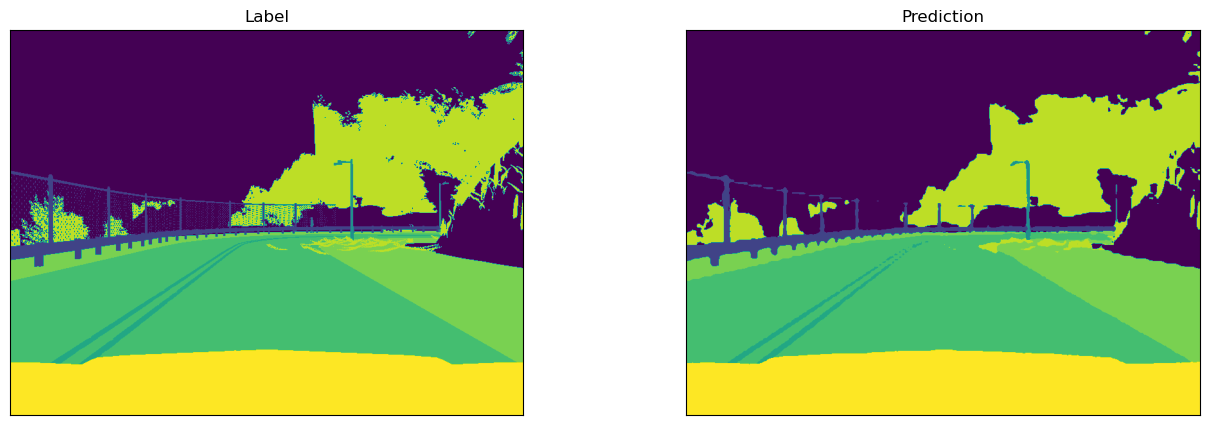

12it [00:20,  1.61s/it]

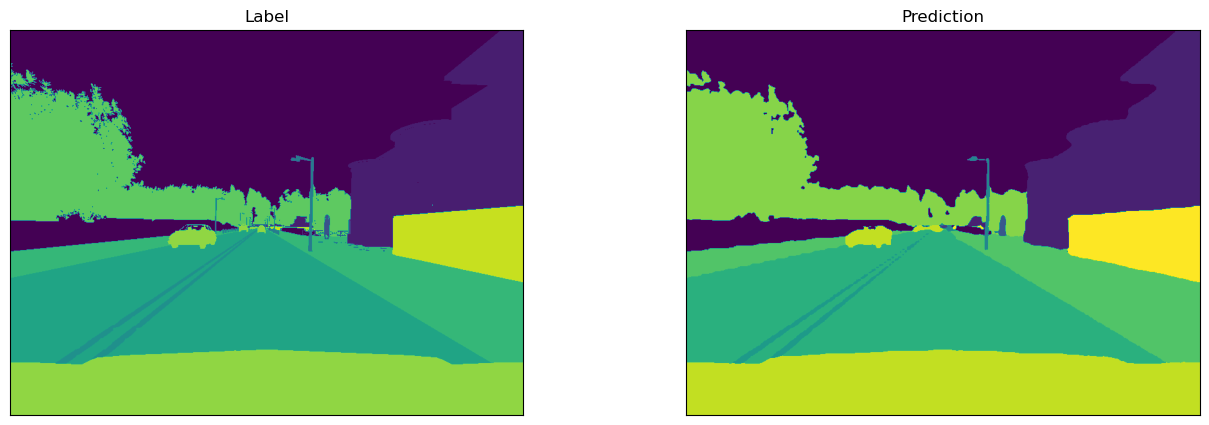

13it [00:21,  1.61s/it]

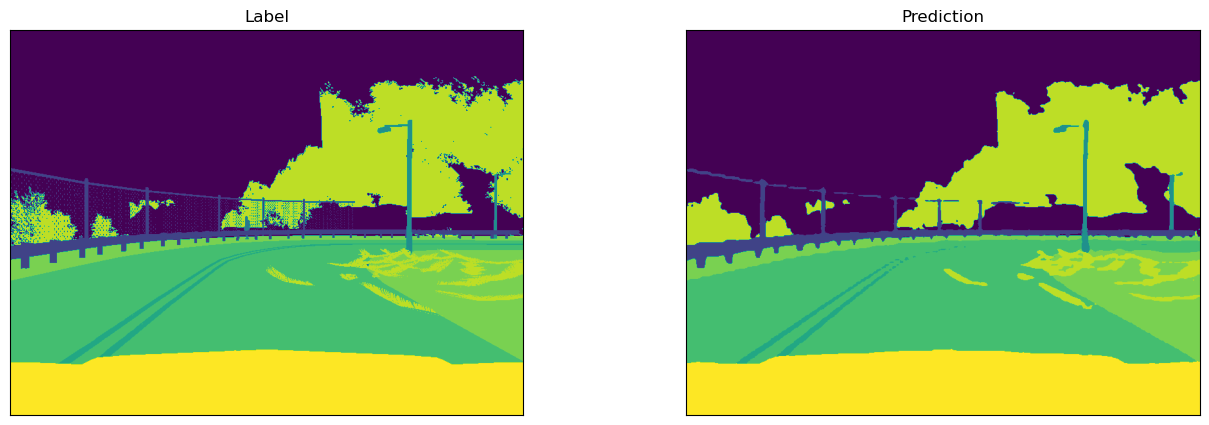

14it [00:23,  1.60s/it]

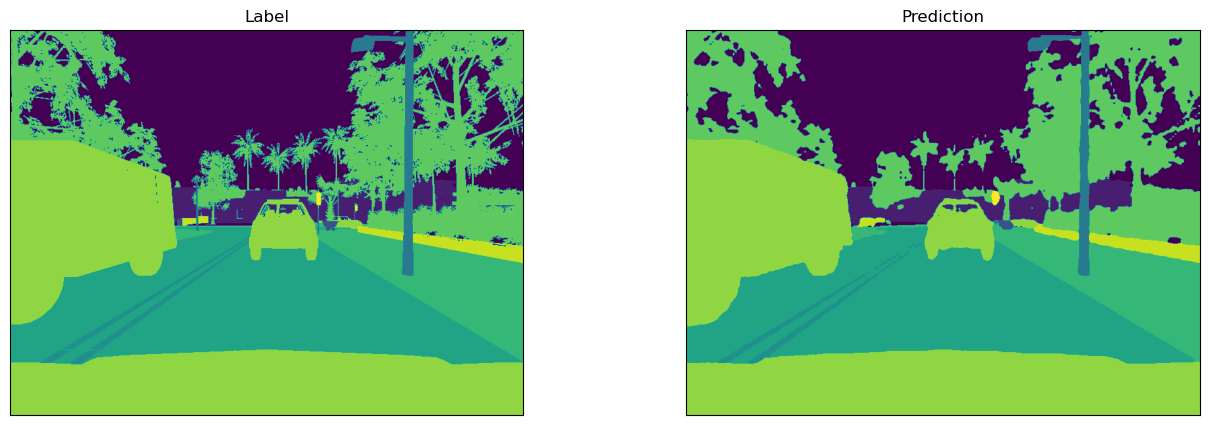

15it [00:25,  1.61s/it]

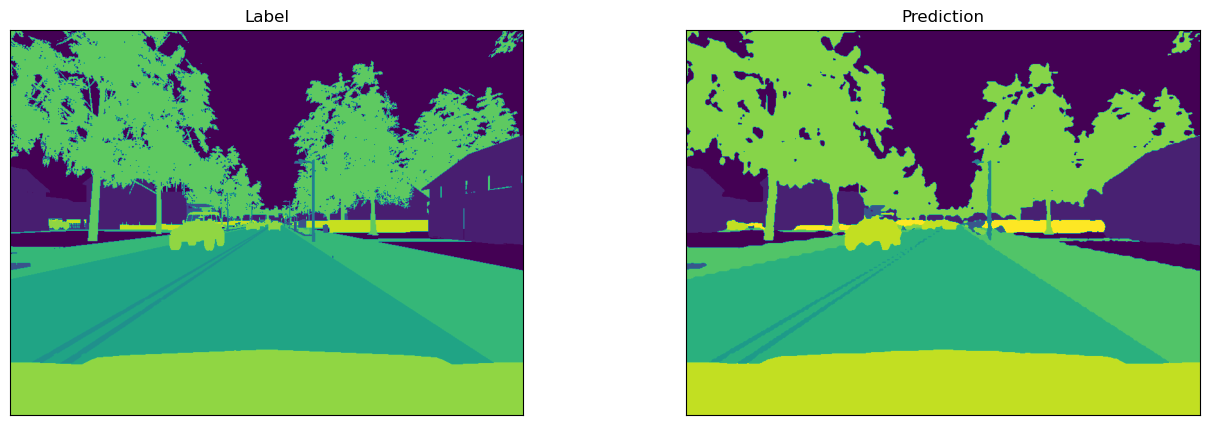

16it [00:26,  1.60s/it]

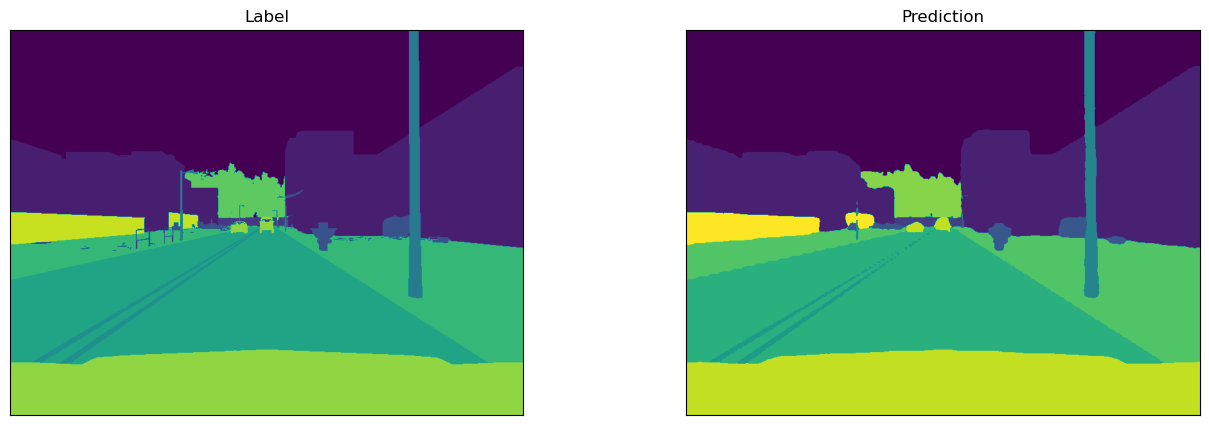

17it [00:28,  1.62s/it]

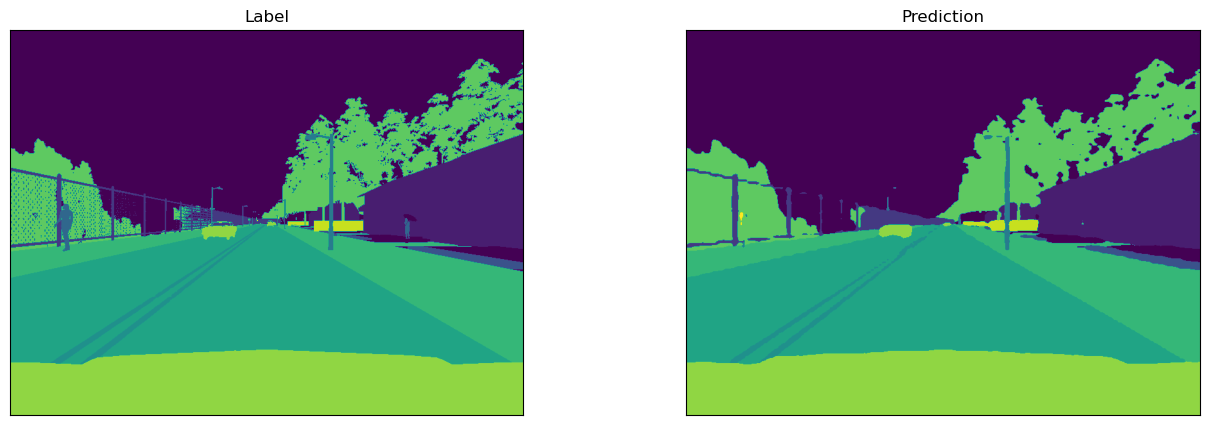

18it [00:31,  1.73s/it]


KeyboardInterrupt: 

In [24]:
for i,(image, mask) in tqdm(enumerate(val_dataloader)):
    image = image.to(device)
    prediction = test_model(image).logits
    prediction = F.interpolate(prediction, scale_factor=4, mode='bilinear', align_corners=False)
    ### segmentation이기에 가장 확률이 높은 index만을 찾아줍니다.
    prediction = prediction.argmax(dim=1).detach().cpu()[0]
    visualize( label=mask.argmax(dim=1)[0], 
    prediction = prediction)
